# TP 3 - Planning (November 30)


![ChessUrl](https://gymnasium.farama.org/_images/frozen_lake.gif "Frozen Lake")

In this assignement, we focus on algorithms that require a **model** of the environment behavior. You will implement :

- A Monte Carlo Tree Search Algorithm
- A Tabular Dyna-Q Algorithm

You will be evaluated on:
* Implementation of the agents. Points will be granted to clean, scalable code.
* A Paragraph of analysis of the behavior of the algorithms . 

Send this notebook  to cyriaque.rousselot@inria.fr before next course.


In [2]:
%load_ext autoreload
%autoreload 1
%aimport utils

## Environment

### Snapshots

For the sake of planning algorithm, we will introduce the possibility of taking snapshots of the environment. Snapshots allows to return to a previously visited state.

In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio
import cv2

import gymnasium as gym

import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout

from IPython.display import Image, display

In [631]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=200, is_slippery=False))
env.reset()
n_actions = env.action_space.n
n_states = env.observation_space.n

In [632]:
print("initial_state:")
print(env.render())
# plt.axis('off')
env.close()

# create first snapshot
snap0 = env.get_snapshot()

initial_state:

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [633]:
while True:
    _, _, terminated, truncated, _ = env.step(env.action_space.sample())
    if terminated:
        print("Whoops! We died!")
        break
    if truncated:
        print("Time is over!")
        break

print("final state:")
print(env.render())
env.close()

Whoops! We died!
final state:
  (Down)
SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



In [634]:
# reload initial state
env.load_snapshot(snap0)

print("After loading snapshot")
print(env.render())
env.close()

After loading snapshot

SFFFFFFF
FFFFFFFF
FFFHFFFF
FFFFFHFF
FFFHFFFF
FHHFFFHF
FHFFHFHF
FFFHFFFG



## Monte Carlo Tree Search

https://en.wikipedia.org/wiki/Monte_Carlo_tree_search ; Sutton-Barto Chapter 8.11

The MCTS algorithm we will implement can be divided in 4 steps:
- Selection 
- Expansion
- Simulation
- Backpropagation

The first step is exploring the current tree using a UCB-1 rule until we get to a leaf L .

The second is creating a child C from feasable moves after the leaf L if the game is not finished.

The third is simulating the end of the game with an unbiased method to get an estimate of the value of the position C.

The fourth is updating the value estimation of the position of all nodes visited during the exploration of the tree.



![image.png](https://i.postimg.cc/6QmwnjPS/image.png)

We will use snapshots to simulate the effect of a sample model:
1. Saving a snapshot of state S
2. sending S,A to the environement
3. Getting back R and S'
4. When needed, loading the snapshot of state S

## Building the agent:

> Fill the blanks in the code

In [635]:
class Node:
    """A node in the Monte Carlo Tree Search (MCTS) algorithm."""
    
    #metadata:
    parent = None          #parent Node
    qvalue_sum = 0.         #sum of state values from all visits (numerator)
    times_visited = 0      #counter of visits (denominator)

    action_dict = {0: "left", 1: "down", 2: "right", 3: "up"}

    def __init__(self, parent, action):
        """
        Initializes a tree node with a parent, action, and environment.

        :param parent: parent TreeNode
        :param action: action to commit from parent Node
        """

        self.parent = parent
        self.action = action
        self.children = []
        self.depth = 0 if parent is None else parent.depth + 1

        # Capture the outcome after performing the action in the parent's state
        result = env.get_result(parent.snapshot, action)
        (
            self.snapshot,
            self.observation,
            self.immediate_reward,
            self.is_done,
            _,
            _
        ) = result

    def is_leaf(self):
        return not self.children

    def is_root(self):
        return self.parent is None

    def get_qvalue_estimate(self):
        if self.times_visited !=0:
            return self.qvalue_sum / self.times_visited
        return 0

    def ucb_score(self, scale=2, max_value=float("inf")):
        """
        Computes the Upper Confidence Bound (UCB) score for the node.

        :param scale: Multiplies the upper bound by this value. Assumes reward range to be [0, scale].
        :param max_value: a value representing infinity (for unvisited nodes).
        """
        if self.times_visited == 0:
            return max_value

        mu = self.get_qvalue_estimate() 
        t = self.parent.times_visited
        n = self.times_visited
        return mu + scale * np.sqrt(np.log(t) / n)
    
    def select_best_child(self):
        """
        Returns the child with the highest UCB score.
        """
        children = self.children
        children_scores = [child.ucb_score() for child in children]
        best_score = np.argmax(children_scores)
        best_child = children[best_score]
        return best_child

    # MCTS steps
    def select_best_leaf(self):
        """
        Selects the leaf with the highest priority to expand.

        Recursively picks nodes with the best UCB score until it reaches a leaf.
        """
        # Using the UCB valuation, select the best possible child among children of a node
        if self.is_leaf():
            return self
        
        best_child = self.select_best_child()
        return best_child.select_best_leaf()

    def expand(self):
        """
        Expands the current node by creating all possible child nodes.

        Returns one of those children.
        """
        # You can't generate a child if there is already an existing child with the same associated action.

        assert not self.is_done, "Can't expand from terminal state"

        x = self.observation//8
        y = self.observation%8

        actions = [0,1,2,3]

        if x == 0:
            actions.remove(3)
        elif x == 7:
            actions.remove(1)
        if y == 0:
            actions.remove(0)
        elif y == 7:
            actions.remove(2)

        if self.action is not None:
            if (self.action == 0) and (2 in actions):
                actions.remove(2)
            elif (self.action == 1) and (3 in actions):
                actions.remove(3)
            elif (self.action == 2) and (0 in actions):
                actions.remove(0)
            elif (self.action == 3) and (1 in actions):
                actions.remove(1)

        self.children = [Node(self, action) for action in actions]

        return self.select_best_leaf()

    def rollout(self, t_max=10**4):
        """
        Plays the game from this state to the end (done) or for t_max steps.

        On each step, picks an action at random.

        Computes the sum of rewards from the current state until the end of the episode.

        If the node is terminal, return the immediate reward
        """

        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done

        if is_done:
            return self.immediate_reward

        rollout_reward = 0
        t = 0
        while not is_done and t<t_max:
            action = env.action_space.sample() # random rollout policy
            obs, reward, is_done, _, _ = env.step(action)
            rollout_reward += reward
            t += 1
            
        return rollout_reward

    def propagate(self, child_qvalue):
        """
        Uses the child Q-value to update parents number of visits and qvalue recursively.
        """
        my_qvalue = self.immediate_reward + child_qvalue

        # Update qvalue_sum and times_visited
        self.qvalue_sum += my_qvalue
        self.times_visited += 1

        # Propagate upwards
        if not self.is_root():
            self.parent.propagate(my_qvalue)

    def safe_delete(self):
        """safe delete to prevent memory leak in some python versions"""
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child

    def print_policy(self):
        if self.is_root():
            print("root")
        else:
            print("action: ", self.action_dict[self.action], " qvalue estimate: ", self.get_qvalue_estimate())
        
        if not self.is_leaf():
            best_child = self.select_best_child()
            best_child.print_policy()

    def count_nodes(self):
        if self.is_leaf():
            return 1
        else:
            return 1 + sum(child.count_nodes() for child in self.children)
        
    def get_max_depth(self):
        if self.is_leaf():
            return 1
        else:
            return 1 + max(child.get_max_depth() for child in self.children)

    def get_observations(self):
        if self.is_leaf():
            return [self.observation]
        
        else:
            return [self.observation] + [obs for child in self.children for obs in child.get_observations()]

    def __str__(self) -> str:
        x = self.observation//8
        y = self.observation%8
        return f"{x},{y}\nq:{self.get_qvalue_estimate():.3f}"

    def __repr__(self) -> str:
        return self.__str__() 

In [636]:
class Root(Node):
    """The root node"""

    def __init__(self, snapshot, observation):
        self.parent = self.action = None
        self.children = []
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False
        self.depth = 0

    @staticmethod
    def from_node(node):
        root = Root(node.snapshot, node.observation)
        # Copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root
    
    def plot_node_counts(self):
        grid = np.zeros((8,8))
        positions, counts = np.unique(self.get_observations(), return_counts=True)
        xx = positions//8
        yy = positions%8
        grid[xx, yy] = counts

        plt.imshow(grid, cmap='viridis')
        for i in range(8):
            for j in range(8):
                plt.text(j, i, grid[i, j],
                        ha="center", va="center", color="w")
        plt.xlabel("y")
        plt.ylabel("x")

### Running the MCTS 

In [640]:
def plan_mcts(root, n_iters=10):
    """
    Builds a tree with Monte-Carlo Tree Search for n_iters iterations.
    :param root: Tree node to plan from.
    :param n_iters: Number of select-expand-simulate-propagate loops to make.
    """
    for _ in range(n_iters):
        node = root.select_best_leaf()

        if node.is_done:
            node.propagate(0)
        else:
            node = node.expand()
            rollout_reward = node.rollout()
            node.propagate(rollout_reward)

In [659]:
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                             render_mode="ansi",
                             max_episode_steps=200,
                             is_slippery=False))
root_observation, _ = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot, root_observation)

> Use the MCTS implementation to find the optimal policy and show it. Bonus point will be given to a clear display

In [660]:
plan_mcts(root, n_iters=10000)

In [661]:
root.count_nodes()

10762

In [662]:
root.get_max_depth()

17

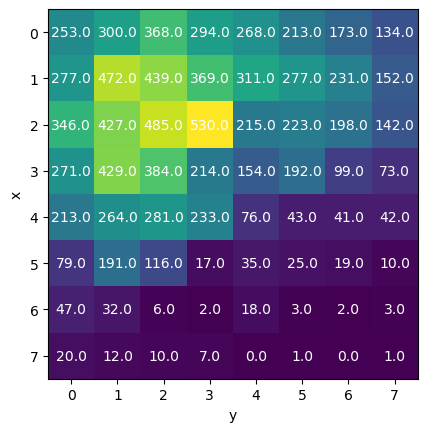

In [663]:
root.plot_node_counts()

In [664]:
root.print_policy()

root
action:  right  qvalue estimate:  0.41562064156206413
action:  right  qvalue estimate:  0.5768153415212238
action:  right  qvalue estimate:  0.7147435897435898
action:  right  qvalue estimate:  0.8201350521792511
action:  right  qvalue estimate:  0.8841443230718306
action:  right  qvalue estimate:  0.921007243877199
action:  right  qvalue estimate:  0.9404719971821064
action:  down  qvalue estimate:  0.9404719971821064
action:  down  qvalue estimate:  0.9514978601997147
action:  down  qvalue estimate:  0.9610951008645533
action:  down  qvalue estimate:  0.9708879184861717
action:  down  qvalue estimate:  0.9805218669606762
action:  down  qvalue estimate:  0.9903489235337788
action:  down  qvalue estimate:  1.0


In [665]:
G = nx.DiGraph()

def add_node_to_graph(node, add_children=True):
    label = f"Q: {node.get_qvalue_estimate():.2f}\nVisits: {node.times_visited}"
    G.add_node(node, label=label)
    if node.parent:
        action_label = f"Action: {node.action_dict[node.action]}"
        G.add_edge(node.parent, node, label=action_label)
    
    if node.children and add_children:
        children_scores = [child.ucb_score() for child in node.children]
        best_ix = np.argmax(children_scores)

        for i, child in enumerate(node.children):
            add_children = i == best_ix
            add_node_to_graph(child, add_children=add_children)

In [666]:
add_node_to_graph(root)

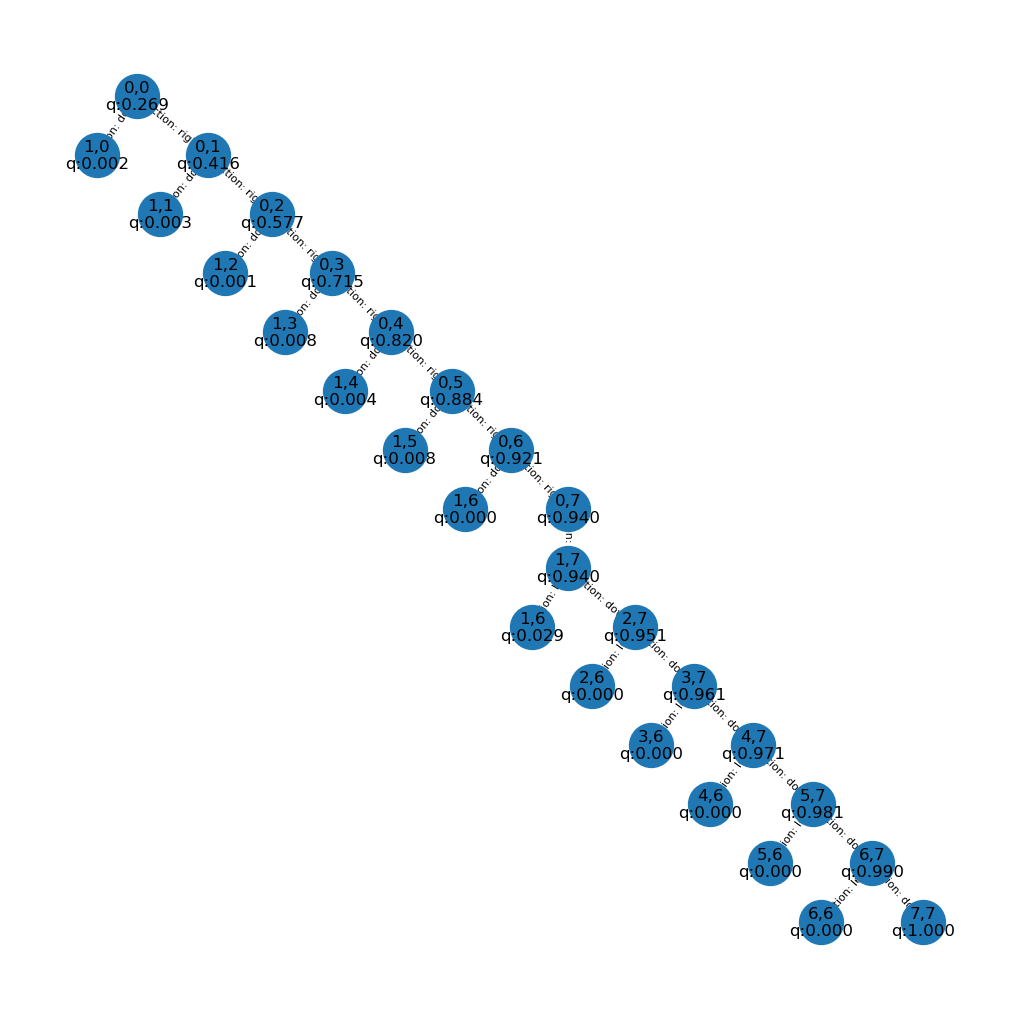

In [667]:
plt.figure(figsize=(10, 10))
pos = graphviz_layout(G, prog="dot",) 
nx.draw(G, pos, with_labels=True, node_size=1000)
edge_labels = nx.get_edge_attributes(G, 'label', )
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
plt.show()

> Try it also on the Cartpole problem:

In [549]:
class Node:
    """A node in the Monte Carlo Tree Search (MCTS) algorithm."""
    
    #metadata:
    parent = None          #parent Node
    qvalue_sum = 0.         #sum of state values from all visits (numerator)
    times_visited = 0      #counter of visits (denominator)

    action_dict = {0: "left", 1: "right"}

    def __init__(self, parent, action):
        """
        Initializes a tree node with a parent, action, and environment.

        :param parent: parent TreeNode
        :param action: action to commit from parent Node
        """

        self.parent = parent
        self.action = action
        self.children = []

        # Capture the outcome after performing the action in the parent's state
        result = env.get_result(parent.snapshot, action)
        (
            self.snapshot,
            self.observation,
            self.immediate_reward,
            self.is_done,
            _,
            _
        ) = result

    def is_leaf(self):
        return not self.children

    def is_root(self):
        return self.parent is None

    def get_qvalue_estimate(self):
        if self.times_visited !=0:
            return self.qvalue_sum / self.times_visited
        return 0

    def ucb_score(self, scale=2, max_value=float("inf")):
        """
        Computes the Upper Confidence Bound (UCB) score for the node.

        :param scale: Multiplies the upper bound by this value. Assumes reward range to be [0, scale].
        :param max_value: a value representing infinity (for unvisited nodes).
        """
        if self.times_visited == 0:
            return max_value

        mu = self.get_qvalue_estimate() 
        t = self.parent.times_visited
        n = self.times_visited
        return mu + scale * np.sqrt(np.log(t) / n)
    
    def select_best_child(self):
        """
        Returns the child with the highest UCB score.
        """
        children = self.children
        children_scores = [child.ucb_score() for child in children]
        best_score = np.argmax(children_scores)
        best_child = children[best_score]
        return best_child

    # MCTS steps
    def select_best_leaf(self):
        """
        Selects the leaf with the highest priority to expand.

        Recursively picks nodes with the best UCB score until it reaches a leaf.
        """
        # Using the UCB valuation, select the best possible child among children of a node
        if self.is_leaf():
            return self
        
        best_child = self.select_best_child()
        return best_child.select_best_leaf()

    def expand(self):
        """
        Expands the current node by creating all possible child nodes.

        Returns one of those children.
        """
        # You can't generate a child if there is already an existing child with the same associated action.

        assert not self.is_done, "Can't expand from terminal state"

        actions = [0,1]

        self.children = [Node(self, action) for action in actions]

        return self.select_best_leaf()

    def rollout(self, t_max=1000):
        """
        Plays the game from this state to the end (done) or for t_max steps.

        On each step, picks an action at random.

        Computes the sum of rewards from the current state until the end of the episode.

        If the node is terminal, return the immediate reward
        """

        env.load_snapshot(self.snapshot)
        obs = self.observation
        is_done = self.is_done

        if is_done:
            return self.immediate_reward

        rollout_reward = 0
        t = 0
        while not is_done and t<t_max:
            action = env.action_space.sample() # random rollout policy
            obs, reward, is_done, _, _ = env.step(action)
            rollout_reward += reward
            t += 1
            
        return rollout_reward

    def propagate(self, child_qvalue):
        """
        Uses the child Q-value to update parents number of visits and qvalue recursively.
        """
        my_qvalue = self.immediate_reward + child_qvalue

        # Update qvalue_sum and times_visited
        self.qvalue_sum += my_qvalue
        self.times_visited += 1

        # Propagate upwards
        if not self.is_root():
            self.parent.propagate(my_qvalue)

    def safe_delete(self):
        """safe delete to prevent memory leak in some python versions"""
        del self.parent
        for child in self.children:
            child.safe_delete()
            del child

    def __str__(self) -> str:
        return f"{self.observation}\nq:{self.get_qvalue_estimate():.3f}"

    def __repr__(self) -> str:
        return self.__str__() 

In [550]:
class Root(Node):
    """The root node"""

    def __init__(self, snapshot, observation):
        self.parent = self.action = None
        self.children = []
        self.snapshot = snapshot
        self.observation = observation
        self.immediate_reward = 0
        self.is_done = False
        self.depth = 0

    @staticmethod
    def from_node(node):
        root = Root(node.snapshot, node.observation)
        # Copy data
        copied_fields = ["qvalue_sum", "times_visited", "children", "is_done"]
        for field in copied_fields:
            setattr(root, field, getattr(node, field))
        return root

In [551]:
env = utils.WithSnapshots(gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=200))

In [552]:
root_observation, _ = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot, root_observation)

In [553]:
images = []
data = []
for _ in range(5000):
    plan_mcts(root, n_iters=10) # simulate 10 steps 
    env.load_snapshot(root.snapshot) # reset the environment to the root state
    action = root.select_best_child().action # select the best action to take from the root
    root = Root.from_node(root.children[action]) # move the root node to the child corresponding to the action
    state, reward, done, truncated, _ = env.step(action) # take the action
    data.append(state) # save the state
    images.append(env.render()) # save the image
    if done:
        print('done')
        break
    if truncated:
        print('time is over')
        break

time is over


In [554]:
data = np.array(data)
data = pd.DataFrame(data, columns=['x', 'v', 'theta', 'omega'])

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

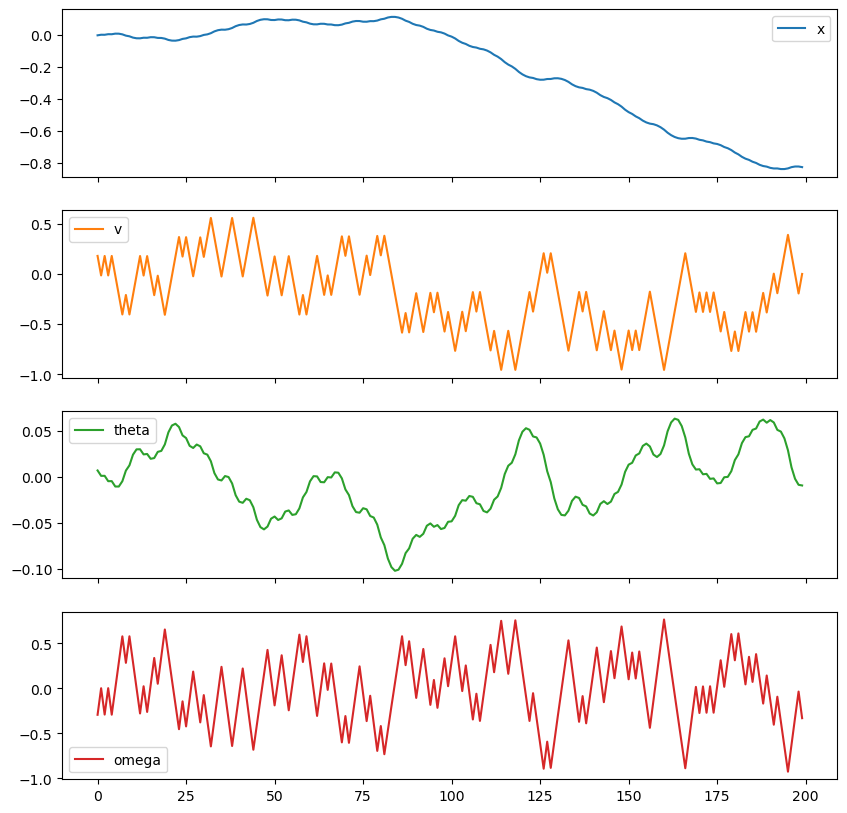

In [555]:
data.plot(subplots=True, figsize=(10, 10))

In [556]:
for i, img in enumerate(images):
    # Define the text properties
    text = f"Iteration: {i+1}"
    font = cv2.FONT_HERSHEY_SIMPLEX
    position = (10, 50)  # You can change this as needed
    font_scale = 1
    font_color = (255, 0, 0)  # Red color; in BGR format
    line_type = 2

    # Write text on each image
    img_with_text = cv2.putText(img.copy(), text, position, font, font_scale, font_color, line_type)

    images[i] = img_with_text

In [557]:
gif_path = './animation.gif'
imageio.mimsave(gif_path, images, fps=10)

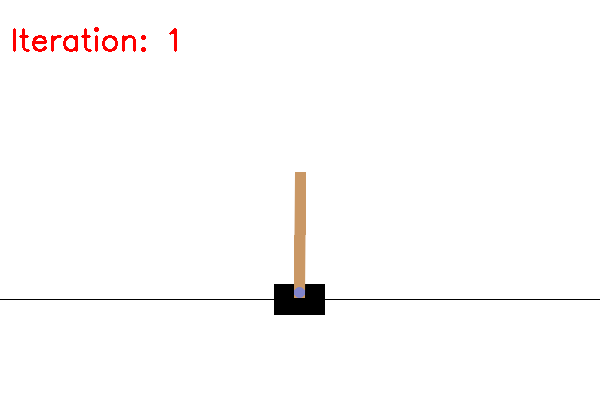

In [558]:
display(Image(filename=gif_path))

## (BONUS) Introducing some Machine Learning

Planning on each iteration can be costly. You can speed things up drastically if you train a classifier to predict which action will turn out to be best according to MCTS.

>To do so, adapt the code and record which action did the MCTS agent take on each step and fit a classifier to [state, mcts_optimal_action]

In [559]:
env = utils.WithSnapshots(gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=500))

In [560]:
root_observation, _ = env.reset()
root_snapshot = env.get_snapshot()
root = Root(root_snapshot, root_observation)

In [561]:
data = []
labels = []
for _ in range(2000):
    plan_mcts(root, n_iters=10) # simulate 10 steps 
    env.load_snapshot(root.snapshot) # reset the environment to the root state
    action = root.select_best_child().action # select the best action to take from the root
    root = Root.from_node(root.children[action]) # move the root node to the child corresponding to the action
    state, reward, done, truncated, _ = env.step(action) # take the action
    data.append(state) # save the state
    labels.append(action) # save the label
    if done or truncated:
        root_observation, _ = env.reset()
        root_snapshot = env.get_snapshot()
        root = Root(root_snapshot, root_observation)

In [562]:
data = np.array(data)

In [563]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [564]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [565]:
np.unique(labels, return_counts=True)

(array([0, 1]), array([1023,  977]))

In [576]:
logistic = LogisticRegression().fit(X_train, y_train)
print(f"Train accuracy: {logistic.score(X_train, y_train)}")
print(f"Test accuracy: {logistic.score(X_test, y_test)}")

Train accuracy: 0.70625
Test accuracy: 0.69


In [577]:
forest = RandomForestClassifier(max_depth=3, n_estimators=150).fit(X_train, y_train)
print(f"Train accuracy: {forest.score(X_train, y_train)}")
print(f"Test accuracy: {forest.score(X_test, y_test)}")

Train accuracy: 0.714375
Test accuracy: 0.69


In [578]:
state, _ = env.reset()

for n in range(500):
    action = forest.predict([state])[0]
    model_prob = forest.predict_proba([state])[0][action]
    state, reward, done, truncated, _ = env.step(action)
    print('Action: {}, Prob: {:.2f}, State: {}'.format(action, model_prob , state))
    if done:
        print('done, we lost :( at iter', n+1)
        break
    if truncated:
        print('time is over')
        break

Action: 0, Prob: 0.54, State: [-0.00039549 -0.18485099 -0.00448133  0.32605138]
Action: 0, Prob: 0.67, State: [-0.00409251 -0.37990886  0.00203969  0.61731774]
Action: 0, Prob: 0.72, State: [-0.01169068 -0.57505924  0.01438605  0.9106424 ]
Action: 0, Prob: 0.68, State: [-0.02319187 -0.77037287  0.0325989   1.2078118 ]
Action: 0, Prob: 0.67, State: [-0.03859932 -0.9659004   0.05675513  1.5105298 ]
Action: 0, Prob: 0.62, State: [-0.05791733 -1.1616622   0.08696573  1.8203768 ]
Action: 0, Prob: 0.60, State: [-0.08115058 -1.3576361   0.12337326  2.1387622 ]
Action: 0, Prob: 0.64, State: [-0.1083033  -1.553743    0.16614851  2.4668667 ]
Action: 0, Prob: 0.63, State: [-0.13937816 -1.7498299   0.21548584  2.8055696 ]
done, we lost :( at iter 9


# Model Learning:  Dyna-Q

> Implement a Tabular Dyna-Q algorithm ( Chapter 8.2 Barto-Sutton) for the Frozen Lake environment

!["Description of Dyna Algorithm"](dyna.png)

In [587]:
# frozen lake env
env = utils.WithSnapshots(gym.make("FrozenLake-v1",map_name="8x8",
                                render_mode="ansi",
                                max_episode_steps=200, is_slippery=False))

In [610]:
class DynaAgent:
    alpha = 0.1
    gamma = 0.9
    
    def __init__(self, env, epsilon=1e-3):
        self.n_actions = env.action_space.n
        self.n_states = env.observation_space.n
        self.epsilon = epsilon
        self.q = np.zeros((n_states,n_actions))
        self.model = np.zeros((n_states,n_actions,2)) # self.model[s,a] return r and s'
        self.env = env
        self.current_state,_ = env.reset()
        self.explored_states = {self.current_state: set()}

    def choose(self):
        if np.random.rand() < self.epsilon:
            action = np.random.choice(self.n_actions)
        else:
            action_values = self.q[self.current_state, :]
            best_actions = np.where(action_values == np.max(action_values))[0]
            action = np.random.choice(best_actions)
        self.explored_states[self.current_state].add(action)
        return action
    
    def record_change(self, state):
        self.current_state = state
        if state not in self.explored_states:
            self.explored_states[state] = set()
    
    def update_model(self,s1,a1,r1,s2):
        self.model[s1,a1] = [r1,s2]

    def update_value(self,s1,a1,r1,s2):
        self.q[s1,a1] = self.q[s1, a1] + self.alpha*(r1 + self.gamma*np.max(self.q[int(s2),:]) - self.q[s1,a1])

    def planning(self,n_steps):
        for _ in range(n_steps):
            s1 = np.random.choice(list(self.explored_states.keys()))
            actions_taken = self.explored_states[s1]
            if len(actions_taken) == 0:
                continue
            a1 = np.random.choice(list(actions_taken))
            r1, s2 = self.model[s1,a1]
            self.update_value(s1,a1,r1,s2)

In [624]:
agent = DynaAgent(env)

In [627]:
for _ in range(1000):
    action = agent.choose()
    state, reward, done, truncated, _ = env.step(action)
    agent.record_change(state)
    agent.update_value(agent.current_state, action, reward, state)
    agent.update_model(agent.current_state, action, reward, state)
    agent.planning(100)

    if done:
        state, _ = env.reset()
        agent.record_change(state)

In [630]:
agent.explored_states

{0: {0, 1, 2, 3},
 8: {0, 1, 2, 3},
 1: {0, 1, 2, 3},
 2: {0, 1, 2, 3},
 3: {0, 1, 2, 3},
 11: {0, 1, 2, 3},
 12: {0, 1, 2, 3},
 20: {0, 1, 2, 3},
 19: set(),
 9: {0, 1, 2, 3},
 17: {0, 1, 2, 3},
 25: {0, 1, 2, 3},
 24: {0, 1, 2, 3},
 26: {0, 1, 2, 3},
 27: {0, 1, 2, 3},
 10: {0, 1, 2, 3},
 16: {0, 1, 2, 3},
 18: {0, 1, 2, 3},
 34: {0, 1, 3},
 33: {0, 1, 2, 3},
 41: set(),
 32: {0, 1, 2, 3},
 4: {0, 1, 2, 3},
 35: set(),
 40: {0, 1, 2, 3},
 42: set(),
 28: {1, 2},
 36: {0},
 5: {0, 1, 2, 3},
 13: {0, 1, 2},
 14: {0, 1, 2, 3},
 6: {0, 1, 2, 3},
 21: {0, 1, 2, 3},
 29: set(),
 7: {0, 2},
 48: {1, 2},
 56: {1, 2, 3},
 57: {0},
 49: set(),
 15: {0, 1},
 22: {0, 1, 2},
 23: {0, 2, 3},
 30: {1, 2, 3},
 38: {1, 2, 3},
 39: {0},
 31: {1},
 46: set()}

> What are some limits of the algorithm ? Does it scale ? Explain. 

_Parts of the code for this practical has been inspired by https://github.com/yandexdataschool/Practical_RL/_